In [12]:
import os, gc, sys
import pygrib
import regionmask
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp
import matplotlib.pyplot as plt 

from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 
cwa = 'SEW'
fhr_start, fhr_end, fhr_step = 24, 24, 6

start_date = datetime(2020, 5, 18, 0)
end_date = datetime(2020, 12, 1, 0)

produce_thresholds = [0.01]#:, 0.1, 0.25, 0.50, 1.0]
bint, bins_custom = 5, None
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 

In [3]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
fig_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/'
os.makedirs(tmp_dir, exist_ok=True)

In [4]:
def cmap_colors(_bins):
    print(_bins)
    
    if _bins == (0, 20):
        return ('#f5f5f5','#d8b365')
    elif _bins in ((20, 40)):
        return ('#5ab4ac','#f5f5f5','#f5f5f5','#d8b365', '#d8b365')
    elif _bins in ((40, 60), (60, 80)):
        return ('#5ab4ac','#5ab4ac','#f5f5f5','#f5f5f5','#d8b365')
    elif _bins in ((80, 100)):
        return ('#5ab4ac','#f5f5f5')

def resize_colobar(event):
    # Tell matplotlib to re-draw everything, so that we can get
    # the correct location from get_position.
    plt.draw()

    posn = ax.get_position()
    colorbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                             0.04, axpos.height])
    
def calc_pbin(pbin, _bint, _thresh, _data, _urma):

    p0, p1 = pbin-_bint/2, pbin+_bint/2
    N = xr.where((_data >= p0) & (_data < p1), 1, 0).sum(dim=['valid'])
    n = xr.where((_data >= p0) & (_data < p1) & (_urma > _thresh), 1, 0).sum(dim='valid')
    
    return pbin, n, N

def calc_pbin_fixed(pbin, _thresh, _data, _urma):

    p0, p1 = pbin
    N = xr.where((_data >= p0) & (_data <= p1), 1, 0).sum(dim=['valid'])
    n = xr.where((_data >= p0) & (_data <= p1) & (_urma > _thresh), 1, 0).sum(dim='valid')
    
    return pbin, n, N

In [5]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))

if not os.path.isfile(urma_dir + 'agg/urma_agg.nc'):
    pass 
    #print('URMA aggregate not found')

else:
    #print('Getting URMA aggregate from file')
    urma = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

urma = urma/25.4
urma = urma.rename('apcp24h_in')
lons, lats = urma.lon, urma.lat

## Regionmask implementation:
-I'm loading the NWS zones shapefile into a pandas geoDataFrame for now - simply metadata + polygons<br><br>
-Regionmask doesn't like to work well with too many metadata fields, so subset to what you actually need (I'm just keeping CWA and geo)<br><br>
-You can skip the bounds step if you're working with smaller data - for me, I saw huge memory and speed improvements forcibly trimming the data array to a square/rectangle box around the polygon I wanted before doing a region mask<br><br>
-The mask produced is just a T/F array. The traditional use of these would be to multiply the data array by the mask (huge memory hog) or use a numpy masked array.<br><br>
-I've found that the best way to apply the mask is with xr.where(mask, IF_TRUE, IF_FALSE), which will produce a masked xarray of your data that you can then easily calculate stats on and/or plot

In [6]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
    
print(bounds)
    
lons, lats = urma.lon, urma.lat
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)
mask

[-124.762578     46.38421249 -120.65499878   49.00241089]


<xarray.DataArray (y: 1051, x: 1132)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1044 1045 1046 1047 1048 1049 1050
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1125 1126 1127 1128 1129 1130 1131
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
    cwa      <U3 'SEW'

#### Trim the grid to bounds above before moving on to save memory and compute time

In [7]:
idx = np.where(
    (urma.lat >= bounds[1]) & (urma.lat <= bounds[3]) &
    (urma.lon >= bounds[0]) & (urma.lon <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.transpose('valid', 'y', 'x')

#### This is the bulk of the application of the mask. The key is the last few lines where I broadcast the mask (which is only x,y and not in dim time) to the 3D (or 4D+) shape of the data array and use xr.where() to return a masked array.

In [9]:
# MUTLITHREAD THIS!

data = {k:{} for k in produce_thresholds}

for fhr in np.arange(fhr_start, fhr_end+1, fhr_step):

    open_file = [f for f in extract_flist if 'fhr%03d'%fhr in f][0]

    # Subset the threshold value
    nbm = xr.open_dataset(open_file)['probx'].sel(
    y=slice(idx[0].min(), idx[0].max()),
    x=slice(idx[1].min(), idx[1].max()))

    # Subset the times
    nbm_time = nbm.valid
    urma_time = urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
    date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = urma.sel(valid=time_match)
    _mask, _nbm, _urma = xr.broadcast(mask, _nbm, _urma)

    _nbm_masked = xr.where(_mask, _nbm, np.nan)
    _urma_masked = xr.where(_mask, _urma, np.nan)

Processing: SEW f024 0.01"
(60, 80)


/uufs/chpc.utah.edu/common/home/u1070830/anaconda3/envs/xlab/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/uufs/chpc.utah.edu/common/home/u1070830/anaconda3/envs/xlab/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


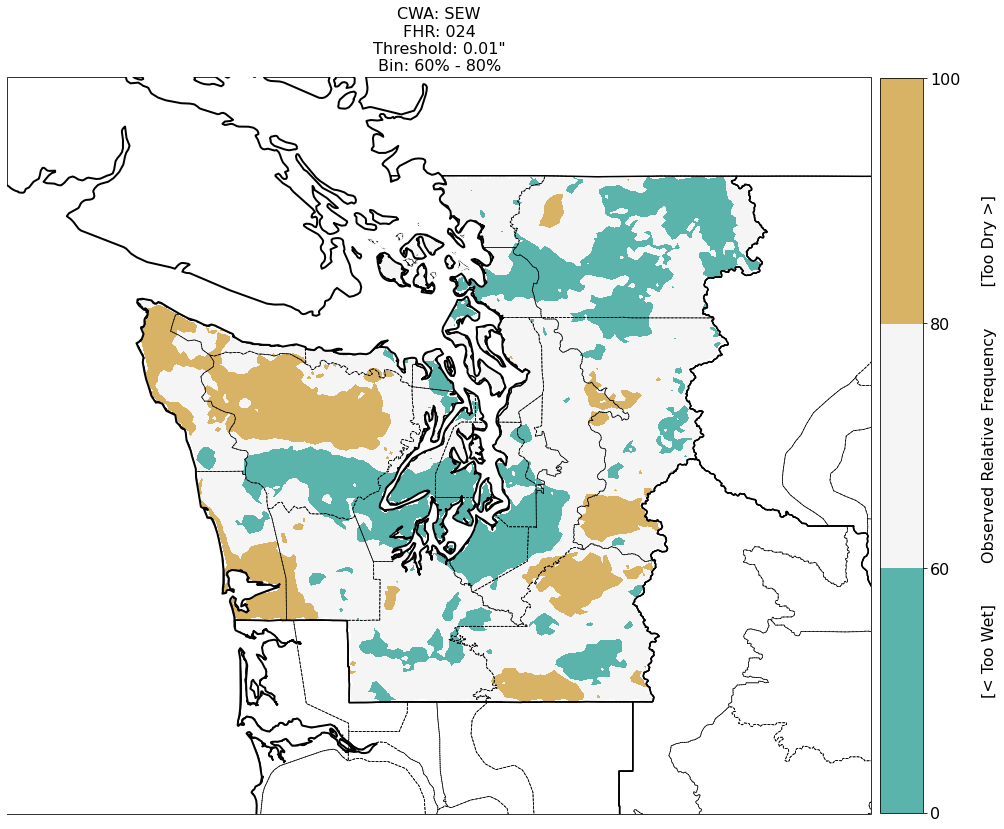

In [11]:
for thresh in produce_thresholds:
        
    print('Processing: %s f%03d %.2f"'%(cwa, fhr, thresh))

    _nbm_masked_select = _nbm_masked.sel(threshold=thresh)

    _data = []
    for bins in [(60, 80)]:

        b0, b1 = bins
        levels = np.unique([0, b0, b1, 100])

        # The meat and potatoes of the thing
        N = xr.where(
                (_nbm_masked_select > b0) & 
                (_nbm_masked_select <= b1), 
            1, 0).sum(dim='valid')

        n = xr.where(
            (_nbm_masked_select > b0) & 
            (_nbm_masked_select <= b1) & 
            (_urma_masked > thresh), 
            1, 0).sum(dim='valid')

        obs_rel_freq = xr.where(n > 5, n/N, np.nan)*100
        _data.append([bins, n, N])

        # Make the plot
        fig = plt.figure(figsize=(12, 12), facecolor='w')
        ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
        cmap = colors.ListedColormap(cmap_colors((b0, b1)), name='orf_cmap')

        if cwa != 'WESTUS':
            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

        cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
        ax.coastlines(linewidth=2, zorder=101)

        obs_rel_freq = obs_rel_freq.sel(threshold=thresh)
        cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, obs_rel_freq,
                         levels=levels, cmap=cmap)

        nan_shade = xr.where(np.isnan(obs_rel_freq) & _mask.isel(valid=0), -1, np.nan)
        ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade.sel(threshold=thresh), cmap='gray', alpha=0.5)

        cbar_ax = fig.add_axes([1.01, .075, .05, .85])
        cbar = plt.colorbar(cbd, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=16)
        fig.canvas.mpl_connect('resize_event', resize_colobar)

        ax.set_title('CWA: %s\nFHR: %03d\nThreshold: %.02f"\nBin: %d%% - %d%%'%(cwa, fhr, thresh, bins[0], bins[1]), fontsize=16)
        cbar.set_label(label='\n[< Too Wet]        Observed Relative Frequency        [Too Dry >]', fontsize=16)

        # ax.set_ylim(bottom=cwa_bounds[cwa][0]+0.05, top=cwa_bounds[cwa][1]+0.085)
        # ax.set_xlim(left=cwa_bounds[cwa][2]-0.15, right=cwa_bounds[cwa][3]+0.15)

        plt.show()

    data[thresh][fhr] = _data

nbm.close()